In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns  
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
%matplotlib inline

A lot of this code is from a blog I found. The next cell is to make a metric for a graph later.

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Download some bitcoin data. Not the most up to date. The most recent data set can be found in yahoo.finance. "Close" prices are the prices of bitcoin when the market closes at 4:30pm. This is not strictly how it works, since bitcoin has after-hours trading. It's a relevant way to think of bitcoin price, however. It's probably not correct to take an average or anything like that

In [3]:
from pandas_datareader import data
pd.core.common.is_list_like = pd.api.types.is_list_like
import fix_yahoo_finance as yf
yf.pdr_override() 

symbol = 'BTC-USD'
data_source='yahoo'
start_date = '2017-01-01'
end_date = '2018-07-15'
df = data.get_data_yahoo(symbol, start_date, end_date)
df.head(10)

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.380005,1001.609985,956.099976,995.440002,995.440002,40570922
2017-01-02,995.440002,1031.680054,990.200012,1017.049988,1017.049988,66038073
2017-01-03,1017.049988,1035.469971,1006.530029,1033.300049,1033.300049,56085870
2017-01-04,1033.300049,1148.540039,1022.320007,1135.410034,1135.410034,170584623
2017-01-05,1135.410034,1150.630005,874.530029,989.349976,989.349976,244839289
2017-01-06,989.349976,1027.420044,852.549988,886.159973,886.159973,179160668
2017-01-07,886.159973,900.859985,806.659973,888.869995,888.869995,113037531
2017-01-08,888.869995,936.130005,875.849976,900.859985,900.859985,70298340
2017-01-09,900.859985,910.469971,870.909973,899.780029,899.780029,55963281


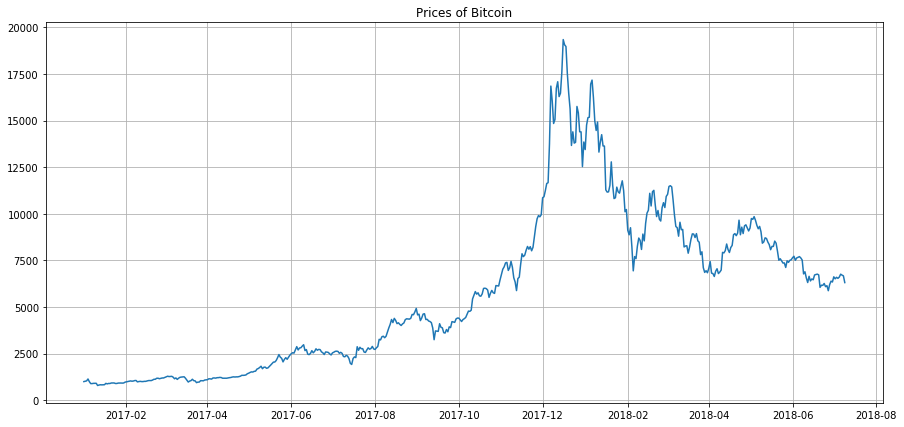

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(df.Close)
plt.title('Prices of Bitcoin')
plt.grid(True)
plt.show()

This computes the time lags for bitcoin. Lag 1 is a one day look back. Lag 10 is a 10 day look back, and so on. Inspecting the columns confirms this is right. Because it's a lookback, it creates NaNs for the first few elements in the data set. We drop the 'y' column later, as we are going to regress on it.

In [6]:
data = pd.DataFrame(df.Close.copy())
data.columns = ["y"]
for i in range(1, 22):
    data["Close_Lag_{}".format(i)] = data.y.shift(i)
display(data.head(7), data.tail(7))

,y,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,Close_Lag_6,Close_Lag_7,Close_Lag_8,Close_Lag_9,...,Close_Lag_12,Close_Lag_13,Close_Lag_14,Close_Lag_15,Close_Lag_16,Close_Lag_17,Close_Lag_18,Close_Lag_19,Close_Lag_20,Close_Lag_21
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,995.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,1017.049988,995.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,1033.300049,1017.049988,995.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,1135.410034,1033.300049,1017.049988,995.440002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,989.349976,1135.410034,1033.300049,1017.049988,995.440002,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,886.159973,989.349976,1135.410034,1033.300049,1017.049988,995.440002,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-07,888.869995,886.159973,989.349976,1135.410034,1033.300049,1017.049988,995.440002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,y,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,Close_Lag_6,Close_Lag_7,Close_Lag_8,Close_Lag_9,...,Close_Lag_12,Close_Lag_13,Close_Lag_14,Close_Lag_15,Close_Lag_16,Close_Lag_17,Close_Lag_18,Close_Lag_19,Close_Lag_20,Close_Lag_21
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-03,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,...,6051.470215,6720.640137,6761.270020,6741.279785,6714.819824,6457.779785,6503.100098,6396.709961,6643.259766,6310.430176
2018-07-04,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,...,6166.540039,6051.470215,6720.640137,6761.270020,6741.279785,6714.819824,6457.779785,6503.100098,6396.709961,6643.259766
2018-07-05,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,...,6157.779785,6166.540039,6051.470215,6720.640137,6761.270020,6741.279785,6714.819824,6457.779785,6503.100098,6396.709961
2018-07-06,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,...,6260.350098,6157.779785,6166.540039,6051.470215,6720.640137,6761.270020,6741.279785,6714.819824,6457.779785,6503.100098
2018-07-07,6707.379883,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,...,6088.390137,6260.350098,6157.779785,6166.540039,6051.470215,6720.640137,6761.270020,6741.279785,6714.819824,6457.779785
2018-07-08,6668.839844,6707.379883,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,...,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,6051.470215,6720.640137,6761.270020,6741.279785,6714.819824
2018-07-09,6306.850098,6668.839844,6707.379883,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,...,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,6051.470215,6720.640137,6761.270020,6741.279785


We do the same lagging process on the trading volume, a measure of how much bitcoin is being  moved around. The actual volume attached to the dates is dropped to avoid look ahead bias.

In [7]:
data1 = pd.DataFrame(df.Volume.copy())
data1.columns = ['y1']
for i in range(1, 22):
    data1['Volume_lag_{}'.format(i)] = data1.y1.shift(i)
del(data1['y1'])
data1.tail(10)

,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5,Volume_lag_6,Volume_lag_7,Volume_lag_8,Volume_lag_9,Volume_lag_10,...,Volume_lag_12,Volume_lag_13,Volume_lag_14,Volume_lag_15,Volume_lag_16,Volume_lag_17,Volume_lag_18,Volume_lag_19,Volume_lag_20,Volume_lag_21
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-30,419284677.0,554799001.0,385907044.0,383457137.0,391396653.0,492834172.0,667479078.0,350697378.0,862826624.0,295690715.0,...,370797057.0,430241689.0,224575526.0,232802782.0,379228601.0,620296377.0,797087281.0,509372466.0,482788065.0,895514425.0
2018-07-01,259708490.0,419284677.0,554799001.0,385907044.0,383457137.0,391396653.0,492834172.0,667479078.0,350697378.0,862826624.0,...,400530201.0,370797057.0,430241689.0,224575526.0,232802782.0,379228601.0,620296377.0,797087281.0,509372466.0,482788065.0
2018-07-02,465915661.0,259708490.0,419284677.0,554799001.0,385907044.0,383457137.0,391396653.0,492834172.0,667479078.0,350697378.0,...,295690715.0,400530201.0,370797057.0,430241689.0,224575526.0,232802782.0,379228601.0,620296377.0,797087281.0,509372466.0
2018-07-03,356390898.0,465915661.0,259708490.0,419284677.0,554799001.0,385907044.0,383457137.0,391396653.0,492834172.0,667479078.0,...,862826624.0,295690715.0,400530201.0,370797057.0,430241689.0,224575526.0,232802782.0,379228601.0,620296377.0,797087281.0
2018-07-04,412202352.0,356390898.0,465915661.0,259708490.0,419284677.0,554799001.0,385907044.0,383457137.0,391396653.0,492834172.0,...,350697378.0,862826624.0,295690715.0,400530201.0,370797057.0,430241689.0,224575526.0,232802782.0,379228601.0,620296377.0
2018-07-05,421189063.0,412202352.0,356390898.0,465915661.0,259708490.0,419284677.0,554799001.0,385907044.0,383457137.0,391396653.0,...,667479078.0,350697378.0,862826624.0,295690715.0,400530201.0,370797057.0,430241689.0,224575526.0,232802782.0,379228601.0
2018-07-06,310759733.0,421189063.0,412202352.0,356390898.0,465915661.0,259708490.0,419284677.0,554799001.0,385907044.0,383457137.0,...,492834172.0,667479078.0,350697378.0,862826624.0,295690715.0,400530201.0,370797057.0,430241689.0,224575526.0,232802782.0
2018-07-07,277167900.0,310759733.0,421189063.0,412202352.0,356390898.0,465915661.0,259708490.0,419284677.0,554799001.0,385907044.0,...,391396653.0,492834172.0,667479078.0,350697378.0,862826624.0,295690715.0,400530201.0,370797057.0,430241689.0,224575526.0
2018-07-08,268455446.0,277167900.0,310759733.0,421189063.0,412202352.0,356390898.0,465915661.0,259708490.0,419284677.0,554799001.0,...,383457137.0,391396653.0,492834172.0,667479078.0,350697378.0,862826624.0,295690715.0,400530201.0,370797057.0,430241689.0


This is a laggin process on the difference of the high and low prices. I wanted to get some notion of variance in the model. Basically, h/l_lag_1 is a 1 day lag on the difference High minus Low. The column with the present dates is dropped to avoid look-ahead bias.

In [8]:
data2 = pd.DataFrame(df.High.copy() - df.Low.copy())
data2.columns = ['y2']
for i in range(1, 22):
    data2['h/l_lag_{}'.format(i)] = data2.y2.shift(i)
del(data2['y2'])
data2.tail(10)

,h/l_lag_1,h/l_lag_2,h/l_lag_3,h/l_lag_4,h/l_lag_5,h/l_lag_6,h/l_lag_7,h/l_lag_8,h/l_lag_9,h/l_lag_10,...,h/l_lag_12,h/l_lag_13,h/l_lag_14,h/l_lag_15,h/l_lag_16,h/l_lag_17,h/l_lag_18,h/l_lag_19,h/l_lag_20,h/l_lag_21
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-30,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,...,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961,482.370117,425.720215,260.959961,852.060059
2018-07-01,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,...,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961,482.370117,425.720215,260.959961
2018-07-02,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,...,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961,482.370117,425.720215
2018-07-03,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,...,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961,482.370117
2018-07-04,366.840332,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,...,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961
2018-07-05,243.089844,366.840332,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,...,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039
2018-07-06,175.299804,243.089844,366.840332,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,...,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668
2018-07-07,296.189942,175.299804,243.089844,366.840332,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,...,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137
2018-07-08,98.700196,296.189942,175.299804,243.089844,366.840332,196.819825,1135.850098,166.779785,308.820312,473.649902,...,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629


Concatenate the dataframes together to get a big dataframe with the thing we want to regress on ('y' = Closing prices) and the lagged features.

In [9]:
btcdata = pd.concat([data, data1, data2], axis=1, sort=False)
btcdata.tail(10)

,y,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,Close_Lag_6,Close_Lag_7,Close_Lag_8,Close_Lag_9,...,h/l_lag_12,h/l_lag_13,h/l_lag_14,h/l_lag_15,h/l_lag_16,h/l_lag_17,h/l_lag_18,h/l_lag_19,h/l_lag_20,h/l_lag_21
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-30,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,6051.470215,...,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961,482.370117,425.720215,260.959961,852.060059
2018-07-01,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,...,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961,482.370117,425.720215,260.959961
2018-07-02,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,...,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961,482.370117,425.720215
2018-07-03,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,...,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961,482.370117
2018-07-04,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,...,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961
2018-07-05,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,...,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039
2018-07-06,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,...,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668
2018-07-07,6707.379883,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,...,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137
2018-07-08,6668.839844,6707.379883,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,...,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629


sklearn has a cross-validation tool for time series. It is to maintain the time structure of the data.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(max_train_size=None, n_splits=5)

I stole this function.

In [12]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

Drops the target variable column, so we we have a matrix of features, and the thing we want to predict

In [13]:
y = btcdata.dropna().y
X = btcdata.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [20]:
display(X_train.tail(10), X_test.tail(10), y_train.tail(10), y_test.tail(10))

,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,Close_Lag_6,Close_Lag_7,Close_Lag_8,Close_Lag_9,Close_Lag_10,...,h/l_lag_12,h/l_lag_13,h/l_lag_14,h/l_lag_15,h/l_lag_16,h/l_lag_17,h/l_lag_18,h/l_lag_19,h/l_lag_20,h/l_lag_21
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-21,12783.940430,11521.759766,11175.519531,11162.700195,11282.490234,13631.980469,13638.629883,14243.120117,13841.190430,13308.059570,...,1168.730468,2400.610352,1393.680664,966.279296,2294.588867,1163.990234,855.299805,2371.969727,1043.860351,1882.390625
2018-01-22,11549.929688,12783.940430,11521.759766,11175.519531,11162.700195,11282.490234,13631.980469,13638.629883,14243.120117,13841.190430,...,1468.950195,1168.730468,2400.610352,1393.680664,966.279296,2294.588867,1163.990234,855.299805,2371.969727,1043.860351
2018-01-23,10814.519531,11549.929688,12783.940430,11521.759766,11175.519531,11162.700195,11282.490234,13631.980469,13638.629883,14243.120117,...,2154.009766,1468.950195,1168.730468,2400.610352,1393.680664,966.279296,2294.588867,1163.990234,855.299805,2371.969727
2018-01-24,10858.230469,10814.519531,11549.929688,12783.940430,11521.759766,11175.519531,11162.700195,11282.490234,13631.980469,13638.629883,...,1277.169922,2154.009766,1468.950195,1168.730468,2400.610352,1393.680664,966.279296,2294.588867,1163.990234,855.299805
2018-01-25,11429.019531,10858.230469,10814.519531,11549.929688,12783.940430,11521.759766,11175.519531,11162.700195,11282.490234,13631.980469,...,764.759766,1277.169922,2154.009766,1468.950195,1168.730468,2400.610352,1393.680664,966.279296,2294.588867,1163.990234
2018-01-26,11175.870117,11429.019531,10858.230469,10814.519531,11549.929688,12783.940430,11521.759766,11175.519531,11162.700195,11282.490234,...,1383.759766,764.759766,1277.169922,2154.009766,1468.950195,1168.730468,2400.610352,1393.680664,966.279296,2294.588867
2018-01-27,11104.200195,11175.870117,11429.019531,10858.230469,10814.519531,11549.929688,12783.940430,11521.759766,11175.519531,11162.700195,...,939.110352,1383.759766,764.759766,1277.169922,2154.009766,1468.950195,1168.730468,2400.610352,1393.680664,966.279296
2018-01-28,11459.709961,11104.200195,11175.870117,11429.019531,10858.230469,10814.519531,11549.929688,12783.940430,11521.759766,11175.519531,...,3616.149414,939.110352,1383.759766,764.759766,1277.169922,2154.009766,1468.950195,1168.730468,2400.610352,1393.680664
2018-01-29,11767.740234,11459.709961,11104.200195,11175.870117,11429.019531,10858.230469,10814.519531,11549.929688,12783.940430,11521.759766,...,2530.919922,3616.149414,939.110352,1383.759766,764.759766,1277.169922,2154.009766,1468.950195,1168.730468,2400.610352


,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,Close_Lag_6,Close_Lag_7,Close_Lag_8,Close_Lag_9,Close_Lag_10,...,h/l_lag_12,h/l_lag_13,h/l_lag_14,h/l_lag_15,h/l_lag_16,h/l_lag_17,h/l_lag_18,h/l_lag_19,h/l_lag_20,h/l_lag_21
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-30,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,6051.470215,6720.640137,...,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961,482.370117,425.720215,260.959961,852.060059
2018-07-01,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,6051.470215,...,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961,482.370117,425.720215,260.959961
2018-07-02,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,...,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961,482.370117,425.720215
2018-07-03,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,...,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961,482.370117
2018-07-04,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,...,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039,433.209961
2018-07-05,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,...,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668,286.540039
2018-07-06,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,...,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137,223.159668
2018-07-07,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,...,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137
2018-07-08,6707.379883,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,...,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629


Date
2018-01-21    11549.929688
2018-01-22    10814.519531
2018-01-23    10858.230469
2018-01-24    11429.019531
2018-01-25    11175.870117
2018-01-26    11104.200195
2018-01-27    11459.709961
2018-01-28    11767.740234
2018-01-29    11233.950195
2018-01-30    10107.259766
Name: y, dtype: float64

Date
2018-06-30    6339.040039
2018-07-01    6615.660156
2018-07-02    6509.580078
2018-07-03    6590.060059
2018-07-04    6534.810059
2018-07-05    6602.020020
2018-07-06    6758.080078
2018-07-07    6707.379883
2018-07-08    6668.839844
2018-07-09    6306.850098
Name: y, dtype: float64

fit linear regression model on the training data

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Stole this next plotting function. If there's a mistake, it's probably in here. Seems to work, though.

In [21]:
def plotModelResults(model, X_train=X_train, X_test=X_test, y_test=y_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

So here we plot the test data using the above function and the confidence interval. The model is *not bad*, but there's actually too many features. Volume, in particular doesn't do anything if we look at the coefficient chart as evidence of importance. Not very good point estimates, but general trend is correct.

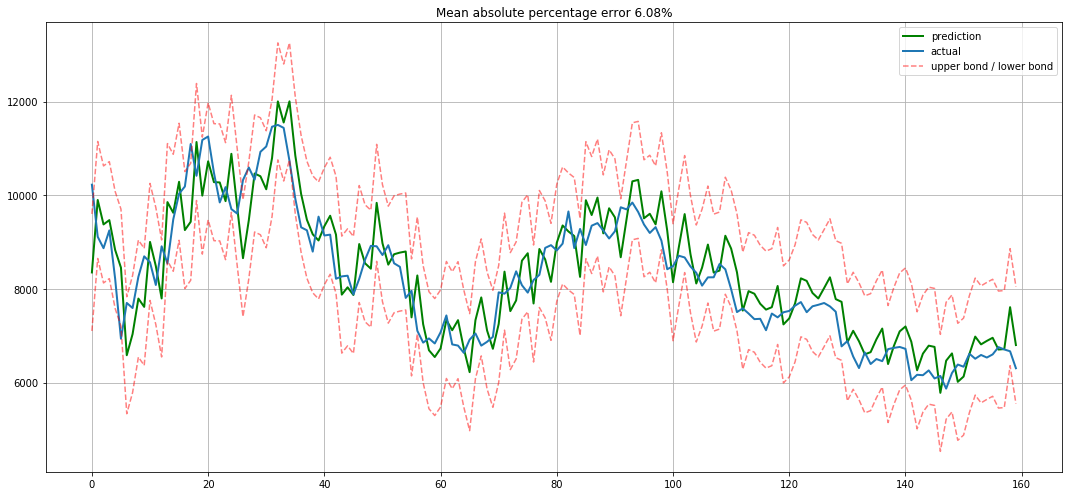

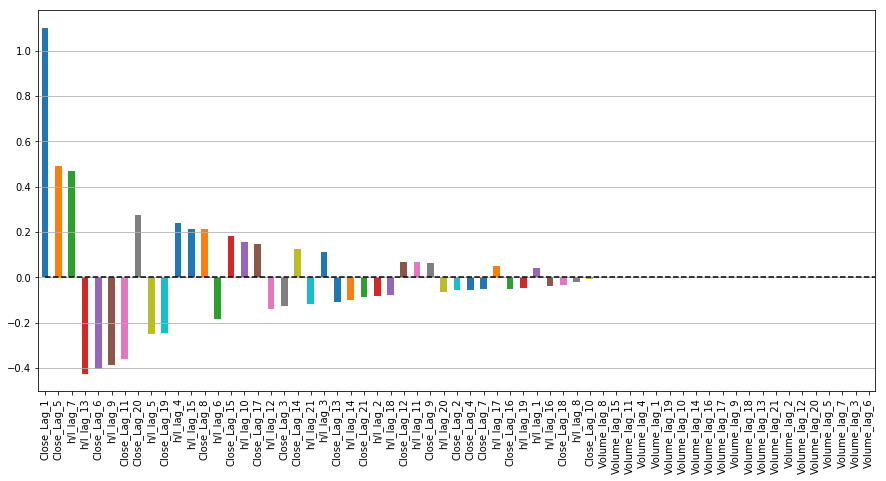

In [22]:
plotModelResults(lr, X_train = X_train, X_test = X_test, y_test=y_test, plot_intervals=True)
plotCoefficients(lr)

It seems like we shouldnt' do as far of a look back, and trading volume does pretty much nothing at all. So we can remove it and tweak our lags. I'm lazy, so I'm going to just copy and paste the previous code with some adjustments. Instead of up to a 21 day lag, we'll do up to a 14 day lag.

In [23]:
data = pd.DataFrame(df.Close.copy())
data.columns = ["y"]
for i in range(1, 15):
    data["Close_Lag_{}".format(i)] = data.y.shift(i)
display(data.head(7), data.tail(7))

,y,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,Close_Lag_6,Close_Lag_7,Close_Lag_8,Close_Lag_9,Close_Lag_10,Close_Lag_11,Close_Lag_12,Close_Lag_13,Close_Lag_14
Date,,,,,,,,,,,,,,,
2017-01-01,995.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,1017.049988,995.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,1033.300049,1017.049988,995.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,1135.410034,1033.300049,1017.049988,995.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,989.349976,1135.410034,1033.300049,1017.049988,995.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,886.159973,989.349976,1135.410034,1033.300049,1017.049988,995.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-07,888.869995,886.159973,989.349976,1135.410034,1033.300049,1017.049988,995.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,y,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,Close_Lag_6,Close_Lag_7,Close_Lag_8,Close_Lag_9,Close_Lag_10,Close_Lag_11,Close_Lag_12,Close_Lag_13,Close_Lag_14
Date,,,,,,,,,,,,,,,
2018-07-03,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,6051.470215,6720.640137,6761.270020
2018-07-04,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,6051.470215,6720.640137
2018-07-05,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,6051.470215
2018-07-06,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039
2018-07-07,6707.379883,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785
2018-07-08,6668.839844,6707.379883,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098
2018-07-09,6306.850098,6668.839844,6707.379883,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137


In [24]:
data2 = pd.DataFrame(df.High.copy() - df.Low.copy())
data2.columns = ['y2']
for i in range(1, 15):
    data2['h/l_lag_{}'.format(i)] = data2.y2.shift(i)
del(data2['y2'])
data2.tail(10)

,h/l_lag_1,h/l_lag_2,h/l_lag_3,h/l_lag_4,h/l_lag_5,h/l_lag_6,h/l_lag_7,h/l_lag_8,h/l_lag_9,h/l_lag_10,h/l_lag_11,h/l_lag_12,h/l_lag_13,h/l_lag_14
Date,,,,,,,,,,,,,,
2018-06-30,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137
2018-07-01,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629
2018-07-02,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903
2018-07-03,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941
2018-07-04,366.840332,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922
2018-07-05,243.089844,366.840332,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942
2018-07-06,175.299804,243.089844,366.840332,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688
2018-07-07,296.189942,175.299804,243.089844,366.840332,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137
2018-07-08,98.700196,296.189942,175.299804,243.089844,366.840332,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195


In [25]:
btcdata = pd.concat([data, data2], axis=1, sort=False)
btcdata.tail(10)

,y,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,Close_Lag_6,Close_Lag_7,Close_Lag_8,Close_Lag_9,...,h/l_lag_5,h/l_lag_6,h/l_lag_7,h/l_lag_8,h/l_lag_9,h/l_lag_10,h/l_lag_11,h/l_lag_12,h/l_lag_13,h/l_lag_14
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-30,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,6051.470215,...,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137
2018-07-01,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,...,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629
2018-07-02,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,...,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903
2018-07-03,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,...,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941
2018-07-04,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,...,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922
2018-07-05,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,...,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942
2018-07-06,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,...,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688
2018-07-07,6707.379883,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,...,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137
2018-07-08,6668.839844,6707.379883,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,...,366.840332,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195


In [26]:
y = btcdata.dropna().y
X = btcdata.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
display(X_train.tail(10), X_test.tail(10), y_train.tail(10), y_test.tail(10))

,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,Close_Lag_6,Close_Lag_7,Close_Lag_8,Close_Lag_9,Close_Lag_10,...,h/l_lag_5,h/l_lag_6,h/l_lag_7,h/l_lag_8,h/l_lag_9,h/l_lag_10,h/l_lag_11,h/l_lag_12,h/l_lag_13,h/l_lag_14
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-19,11175.519531,11162.700195,11282.490234,13631.980469,13638.629883,14243.120117,13841.190430,13308.059570,14919.490234,14468.500000,...,1383.759766,764.759766,1277.169922,2154.009766,1468.950195,1168.730468,2400.610352,1393.680664,966.279296,2294.588867
2018-01-20,11521.759766,11175.519531,11162.700195,11282.490234,13631.980469,13638.629883,14243.120117,13841.190430,13308.059570,14919.490234,...,939.110352,1383.759766,764.759766,1277.169922,2154.009766,1468.950195,1168.730468,2400.610352,1393.680664,966.279296
2018-01-21,12783.940430,11521.759766,11175.519531,11162.700195,11282.490234,13631.980469,13638.629883,14243.120117,13841.190430,13308.059570,...,3616.149414,939.110352,1383.759766,764.759766,1277.169922,2154.009766,1468.950195,1168.730468,2400.610352,1393.680664
2018-01-22,11549.929688,12783.940430,11521.759766,11175.519531,11162.700195,11282.490234,13631.980469,13638.629883,14243.120117,13841.190430,...,2530.919922,3616.149414,939.110352,1383.759766,764.759766,1277.169922,2154.009766,1468.950195,1168.730468,2400.610352
2018-01-23,10814.519531,11549.929688,12783.940430,11521.759766,11175.519531,11162.700195,11282.490234,13631.980469,13638.629883,14243.120117,...,1376.099610,2530.919922,3616.149414,939.110352,1383.759766,764.759766,1277.169922,2154.009766,1468.950195,1168.730468
2018-01-24,10858.230469,10814.519531,11549.929688,12783.940430,11521.759766,11175.519531,11162.700195,11282.490234,13631.980469,13638.629883,...,913.310546,1376.099610,2530.919922,3616.149414,939.110352,1383.759766,764.759766,1277.169922,2154.009766,1468.950195
2018-01-25,11429.019531,10858.230469,10814.519531,11549.929688,12783.940430,11521.759766,11175.519531,11162.700195,11282.490234,13631.980469,...,1528.929687,913.310546,1376.099610,2530.919922,3616.149414,939.110352,1383.759766,764.759766,1277.169922,2154.009766
2018-01-26,11175.870117,11429.019531,10858.230469,10814.519531,11549.929688,12783.940430,11521.759766,11175.519531,11162.700195,11282.490234,...,1685.619140,1528.929687,913.310546,1376.099610,2530.919922,3616.149414,939.110352,1383.759766,764.759766,1277.169922
2018-01-27,11104.200195,11175.870117,11429.019531,10858.230469,10814.519531,11549.929688,12783.940430,11521.759766,11175.519531,11162.700195,...,1845.980468,1685.619140,1528.929687,913.310546,1376.099610,2530.919922,3616.149414,939.110352,1383.759766,764.759766


,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,Close_Lag_6,Close_Lag_7,Close_Lag_8,Close_Lag_9,Close_Lag_10,...,h/l_lag_5,h/l_lag_6,h/l_lag_7,h/l_lag_8,h/l_lag_9,h/l_lag_10,h/l_lag_11,h/l_lag_12,h/l_lag_13,h/l_lag_14
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-30,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,6051.470215,6720.640137,...,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629,139.390137
2018-07-01,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,6051.470215,...,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903,400.619629
2018-07-02,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,6166.540039,...,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941,167.399903
2018-07-03,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,6157.779785,...,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922,247.939941
2018-07-04,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,6260.350098,...,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942,102.419922
2018-07-05,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,6088.390137,...,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688,790.189942
2018-07-06,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,6141.569824,...,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137,224.679688
2018-07-07,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,5871.279785,...,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195,471.890137
2018-07-08,6707.379883,6758.080078,6602.020020,6534.810059,6590.060059,6509.580078,6615.660156,6339.040039,6385.379883,6203.799805,...,366.840332,196.819825,1135.850098,166.779785,308.820312,473.649902,327.970214,170.419922,218.869629,249.200195


Date
2018-01-19    11521.759766
2018-01-20    12783.940430
2018-01-21    11549.929688
2018-01-22    10814.519531
2018-01-23    10858.230469
2018-01-24    11429.019531
2018-01-25    11175.870117
2018-01-26    11104.200195
2018-01-27    11459.709961
2018-01-28    11767.740234
Name: y, dtype: float64

Date
2018-06-30    6339.040039
2018-07-01    6615.660156
2018-07-02    6509.580078
2018-07-03    6590.060059
2018-07-04    6534.810059
2018-07-05    6602.020020
2018-07-06    6758.080078
2018-07-07    6707.379883
2018-07-08    6668.839844
2018-07-09    6306.850098
Name: y, dtype: float64

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Cleaning up the features improves the model a bit. If you ridge this with sklearn, you can get this a little tighter, but this is about as good as it gets using just time lags. But I'm surprised at how good the model seems. The reason I'm surprised is because I tried an auto ARIMA and an exponential smoothing model in R using the forecast package and it was not nearly this good, so I'm wondering if there is some look-ahead bias I am not seeing or the model is super overfit. Doing the same for an AMD set gives a pretty similar result. Btw, if you take away the more recent time lags, the model gets a fair amount worse. Bitcoin data seems to really depend on vary recent trends. In theory, this should make an exponential smoothing model really good, since it's a way of giving more weight to recent observations, but I have no idea why this is working better -- on a hold out set even.

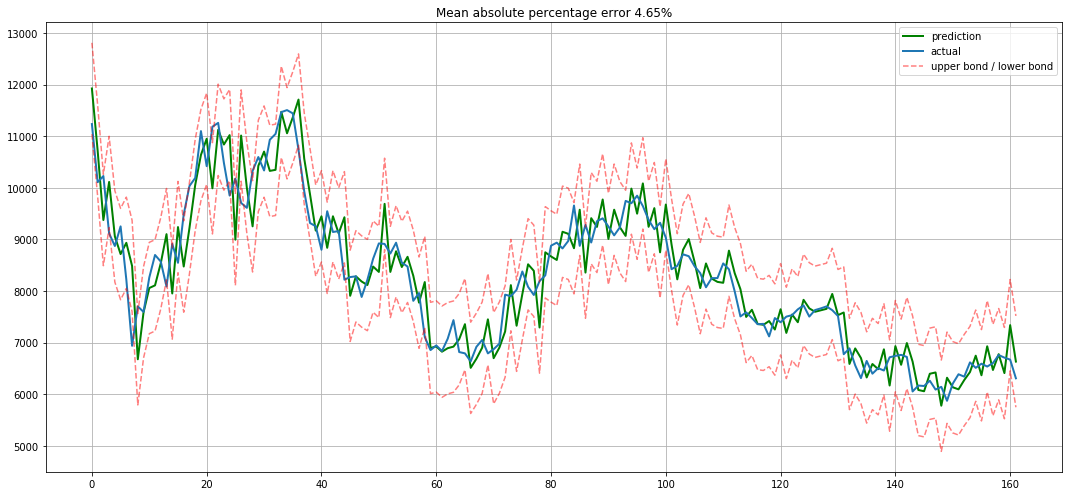

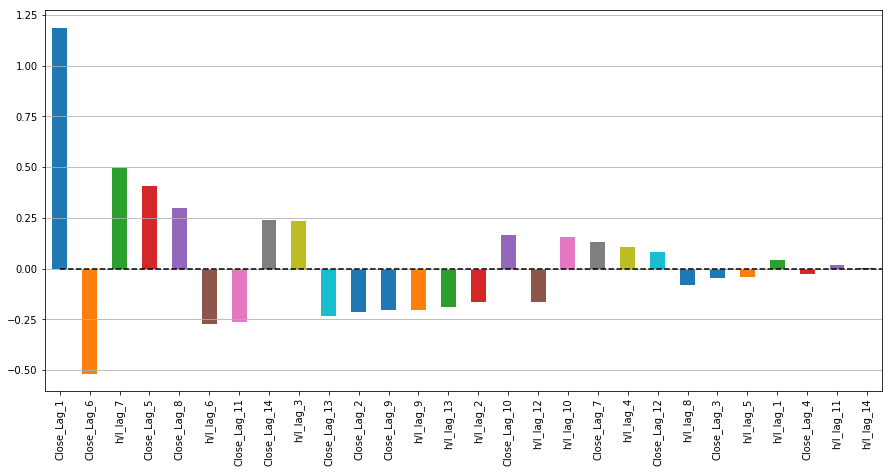

In [28]:
plotModelResults(lr, X_train = X_train, X_test = X_test, y_test=y_test, plot_intervals=True)
plotCoefficients(lr)

some error statistics on the most recent model I guess, let me know if you want a particular one or more info in general

In [35]:
predictions = lr.predict(X_test)
display((y_test - predictions)/y_test, np.mean((y_test - predictions)/y_test))
mean_squared_error(y_true = y_test, y_pred = predictions)

Date
2018-01-29   -0.061347
2018-01-30   -0.060610
2018-01-31    0.083373
2018-02-01   -0.109411
2018-02-02   -0.020902
2018-02-03    0.058053
2018-02-04   -0.086942
2018-02-05   -0.223183
2018-02-06    0.133181
2018-02-07    0.000793
2018-02-08    0.024713
2018-02-09    0.067694
2018-02-10    0.003777
2018-02-11   -0.125680
2018-02-12    0.107759
2018-02-13   -0.081088
2018-02-14    0.106772
2018-02-15    0.081044
2018-02-16    0.013319
2018-02-17    0.041579
2018-02-18   -0.051085
2018-02-19    0.106710
2018-02-20    0.011932
2018-02-21   -0.033930
2018-02-22   -0.118989
2018-02-23    0.116194
2018-02-24   -0.134491
2018-02-25   -0.040303
2018-02-26    0.104064
2018-02-27    0.016089
                ...   
2018-06-10    0.043862
2018-06-11   -0.050208
2018-06-12   -0.061738
2018-06-13    0.048140
2018-06-14   -0.029341
2018-06-15    0.002961
2018-06-16   -0.063639
2018-06-17    0.081633
2018-06-18   -0.028050
2018-06-19    0.028453
2018-06-20   -0.040131
2018-06-21   -0.095757
2018-0

-0.0060532172796180445

256727.5239857406